In [1]:
# import here
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline

---
# Load The Data

In [2]:
# Load pickled data
training_file = "data/train.p"
validation_file = "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

# Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [3]:
# Number of training examples
n_train = len(X_train)
# Number of validation examples.
n_valid = len(X_valid)
# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape[:-1]

# Number of unique classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


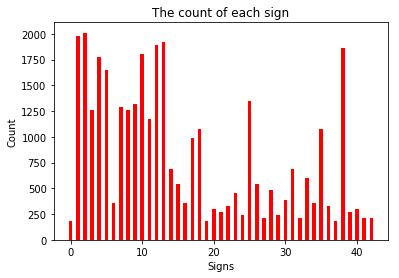

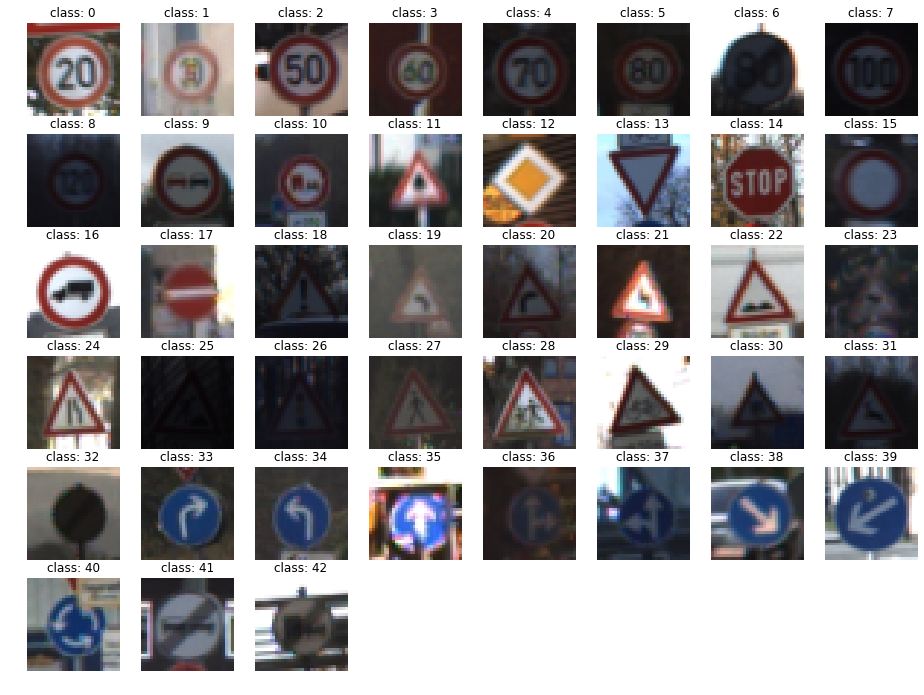

In [4]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_train), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(X_train[i])

----

# Design and Test a Baseline Model Architecture

## Custom Dataset & DataLoader

In [5]:
class PickledDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
        
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])

    def __len__(self):
        return self.count

In [6]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

## Baseline Model

In [7]:
class BaselineNet(nn.Module):
    def __init__(self, gray=False):
        super(BaselineNet, self).__init__()
        input_chan = 1 if gray else 3
        self.conv1 = nn.Conv2d(input_chan, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training

In [8]:
torch.manual_seed(1)

In [9]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def preprocess(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

train_loader = WrappedDataLoader(train_loader, preprocess)
valid_loader = WrappedDataLoader(valid_loader, preprocess)
test_loader = WrappedDataLoader(test_loader, preprocess)

In [11]:
model = BaselineNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 10

In [12]:
def loss_batch(model, loss_func, x, y, opt=None):
    loss = loss_func(model(x), y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)

In [13]:
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    
    return loss.item(), torch.sum(correct).item(), len(x)

In [14]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")

In [15]:
def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        
    print(f"Test loss: {test_loss:.6f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")

In [16]:
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/10] Train loss: 3.675416	Validation loss: 3.591649	 Validation accruacy: 5.556%
[Epoch 2/10] Train loss: 3.484744	Validation loss: 3.570634	 Validation accruacy: 5.986%
[Epoch 3/10] Train loss: 3.457650	Validation loss: 3.540193	 Validation accruacy: 6.667%
[Epoch 4/10] Train loss: 3.341047	Validation loss: 3.351622	 Validation accruacy: 17.188%
[Epoch 5/10] Train loss: 2.717296	Validation loss: 2.372159	 Validation accruacy: 36.939%
[Epoch 6/10] Train loss: 1.726090	Validation loss: 1.634264	 Validation accruacy: 53.424%
[Epoch 7/10] Train loss: 1.151072	Validation loss: 1.177936	 Validation accruacy: 66.712%
[Epoch 8/10] Train loss: 0.860608	Validation loss: 0.976507	 Validation accruacy: 72.676%
[Epoch 9/10] Train loss: 0.681266	Validation loss: 0.959111	 Validation accruacy: 72.585%
[Epoch 10/10] Train loss: 0.564825	Validation loss: 0.822848	 Validation accruacy: 77.279%
Test loss: 1.093436	Test accruacy: 74.323%


---
# Experiment and find tuning

## Data preprocessing

### Image normalize

In [17]:
# Channel separation
red_chan = np.reshape(X_train[:,:,:,0], -1)/255
green_chan = np.reshape(X_train[:,:,:,1], -1)/255
blue_chan = np.reshape(X_train[:,:,:,2], -1)/255

# mean
means = [np.mean(red_chan), np.mean(green_chan), np.mean(blue_chan)]

# std
stds = [np.std(red_chan), np.std(green_chan), np.std(blue_chan)]

print(means)
print(stds)

[0.3399926354902852, 0.31174878670783124, 0.32093609588419364]
[0.2717014855590075, 0.2598821025549765, 0.26575037442309596]


In [18]:
# Add normalize
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.3340, 0.3117, 0.3209), (0.2717, 0.2599, 0.2658))
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), preprocess)

In [19]:
model = BaselineNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/10] Train loss: 3.573530	Validation loss: 3.527760	 Validation accruacy: 7.460%
[Epoch 2/10] Train loss: 3.297276	Validation loss: 3.348538	 Validation accruacy: 13.333%
[Epoch 3/10] Train loss: 2.584592	Validation loss: 2.291309	 Validation accruacy: 36.848%
[Epoch 4/10] Train loss: 1.423564	Validation loss: 1.425291	 Validation accruacy: 56.281%
[Epoch 5/10] Train loss: 0.828985	Validation loss: 1.009158	 Validation accruacy: 68.844%
[Epoch 6/10] Train loss: 0.576775	Validation loss: 0.833956	 Validation accruacy: 75.986%
[Epoch 7/10] Train loss: 0.435694	Validation loss: 0.838276	 Validation accruacy: 76.122%
[Epoch 8/10] Train loss: 0.350524	Validation loss: 0.730077	 Validation accruacy: 80.023%
[Epoch 9/10] Train loss: 0.286713	Validation loss: 0.732504	 Validation accruacy: 79.841%
[Epoch 10/10] Train loss: 0.244588	Validation loss: 0.657186	 Validation accruacy: 81.701%
Test loss: 0.868285	Test accruacy: 80.641%


### Contrast-limited adaptive histogram equalization

In [45]:
class CLAHE:
    def __init__(self, clipLimit=2.0, tileGridSize=(8, 8)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
        img_yuv = cv2.cvtColor(im, cv2.COLOR_RGB2YUV)
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        return img_output
    
class CLAHE_RGB:
    def __init__(self, clipLimit=2.0, tileGridSize=(8, 8)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize
        
    def __call__(self, im):
        r,g,b = cv2.split(im)
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        r,g,b = clahe.apply(r), clahe.apply(g), clahe.apply(b)
        return cv2.merge([r,g,b])

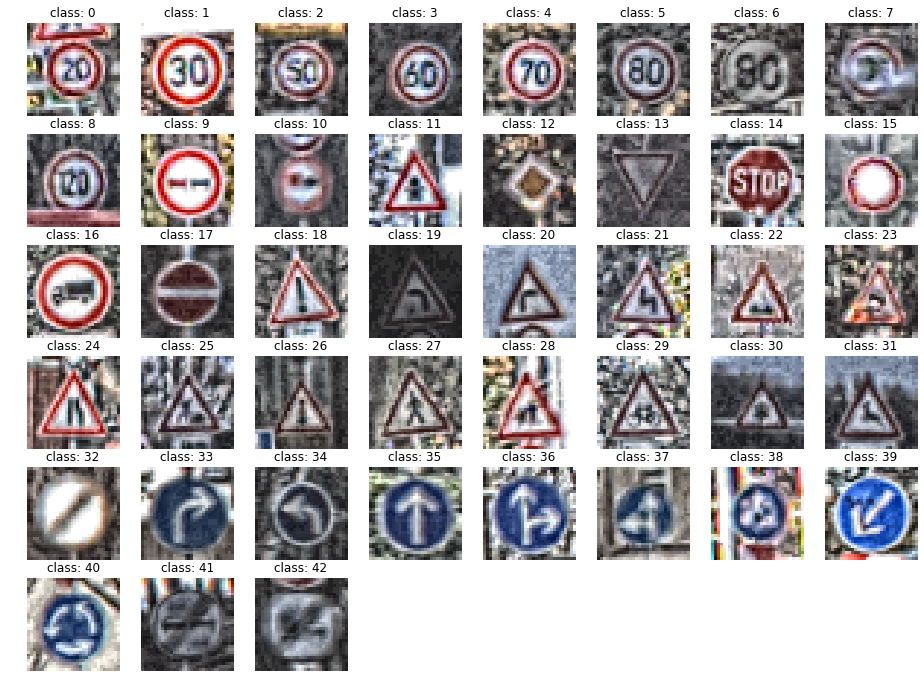

In [46]:
clahe = CLAHE()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(clahe(X_train[i]))

In [54]:
# Apply CLAHE
X_train_clahe = np.array([clahe(x) for x in X_train])

# Channel separation
red_chan = np.reshape(X_train_clahe[:,:,:,0], -1)/255
green_chan = np.reshape(X_train_clahe[:,:,:,1], -1)/255
blue_chan = np.reshape(X_train_clahe[:,:,:,2], -1)/255

# mean
means = [np.mean(red_chan), np.mean(green_chan), np.mean(blue_chan)]

# std
stds = [np.std(red_chan), np.std(green_chan), np.std(blue_chan)]

print(means)
print(stds)

[0.48979965188475316, 0.4619486133805039, 0.47077281421203754]
[0.2475561430858259, 0.24408226795115162, 0.25143887243189583]


In [55]:
data_transforms = transforms.Compose([
    CLAHE(),
    transforms.ToTensor(),
    transforms.Normalize((0.4898, 0.4619, 0.4708), (0.2476, 0.2441, 0.2514))
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), preprocess)

In [56]:
model = BaselineNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/10] Train loss: 3.559654	Validation loss: 3.443647	 Validation accruacy: 11.383%
[Epoch 2/10] Train loss: 2.103857	Validation loss: 1.236378	 Validation accruacy: 62.585%
[Epoch 3/10] Train loss: 0.715695	Validation loss: 0.673229	 Validation accruacy: 80.385%
[Epoch 4/10] Train loss: 0.401109	Validation loss: 0.536134	 Validation accruacy: 84.240%
[Epoch 5/10] Train loss: 0.278865	Validation loss: 0.506488	 Validation accruacy: 87.007%
[Epoch 6/10] Train loss: 0.206573	Validation loss: 0.403514	 Validation accruacy: 88.730%
[Epoch 7/10] Train loss: 0.161329	Validation loss: 0.340327	 Validation accruacy: 90.658%
[Epoch 8/10] Train loss: 0.127473	Validation loss: 0.342879	 Validation accruacy: 90.771%
[Epoch 9/10] Train loss: 0.106204	Validation loss: 0.361454	 Validation accruacy: 90.590%
[Epoch 10/10] Train loss: 0.091991	Validation loss: 0.326892	 Validation accruacy: 91.927%
Test loss: 0.374937	Test accruacy: 90.855%


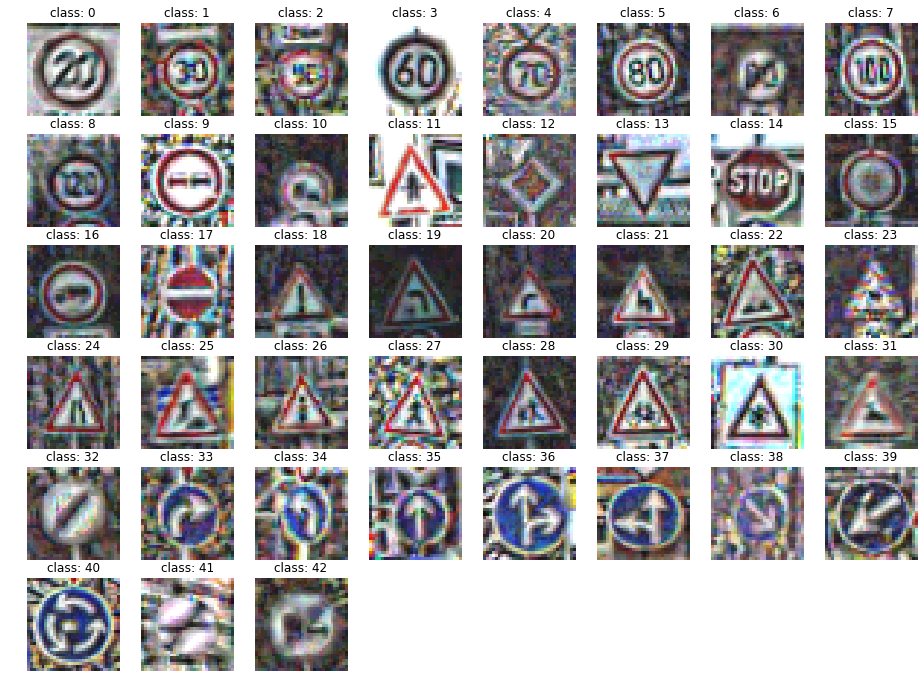

In [57]:
clahe = CLAHE_RGB()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(clahe(X_train[i]))

In [58]:
# Apply CLAHE
X_train_clahe = np.array([clahe(x) for x in X_train])

# Channel separation
red_chan = np.reshape(X_train_clahe[:,:,:,0], -1)/255
green_chan = np.reshape(X_train_clahe[:,:,:,1], -1)/255
blue_chan = np.reshape(X_train_clahe[:,:,:,2], -1)/255

# mean
means = [np.mean(red_chan), np.mean(green_chan), np.mean(blue_chan)]

# std
stds = [np.std(red_chan), np.std(green_chan), np.std(blue_chan)]

print(means)
print(stds)

[0.48207543769657635, 0.47128546659097925, 0.4800727286603284]
[0.24111850691156145, 0.2442877895339099, 0.2438385451964827]


In [59]:
data_transforms = transforms.Compose([
    CLAHE_RGB(),
    transforms.ToTensor(),
    transforms.Normalize((0.4821, 0.4713, 0.4801), (0.2411, 0.2443, 0.2438))
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), preprocess)

In [60]:
model = BaselineNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/10] Train loss: 3.517128	Validation loss: 3.408939	 Validation accruacy: 13.878%
[Epoch 2/10] Train loss: 2.278196	Validation loss: 1.294750	 Validation accruacy: 60.771%
[Epoch 3/10] Train loss: 0.703422	Validation loss: 0.708714	 Validation accruacy: 78.594%
[Epoch 4/10] Train loss: 0.363607	Validation loss: 0.525123	 Validation accruacy: 83.787%
[Epoch 5/10] Train loss: 0.245966	Validation loss: 0.436720	 Validation accruacy: 88.662%
[Epoch 6/10] Train loss: 0.181903	Validation loss: 0.376683	 Validation accruacy: 89.796%
[Epoch 7/10] Train loss: 0.137019	Validation loss: 0.357050	 Validation accruacy: 90.113%
[Epoch 8/10] Train loss: 0.113368	Validation loss: 0.318862	 Validation accruacy: 91.769%
[Epoch 9/10] Train loss: 0.093046	Validation loss: 0.317001	 Validation accruacy: 92.018%
[Epoch 10/10] Train loss: 0.076597	Validation loss: 0.334600	 Validation accruacy: 91.474%
Test loss: 0.400053	Test accruacy: 90.293%


### Grayscale

In [61]:
class CLAHE_GRAY:
    def __init__(self, clipLimit=2.0, tileGridSize=(8, 8)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
        img_y = cv2.cvtColor(im, cv2.COLOR_RGB2YUV)[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        img_y = clahe.apply(img_y)
        img_output = img_y.reshape(img_y.shape + (1,))
        return img_output

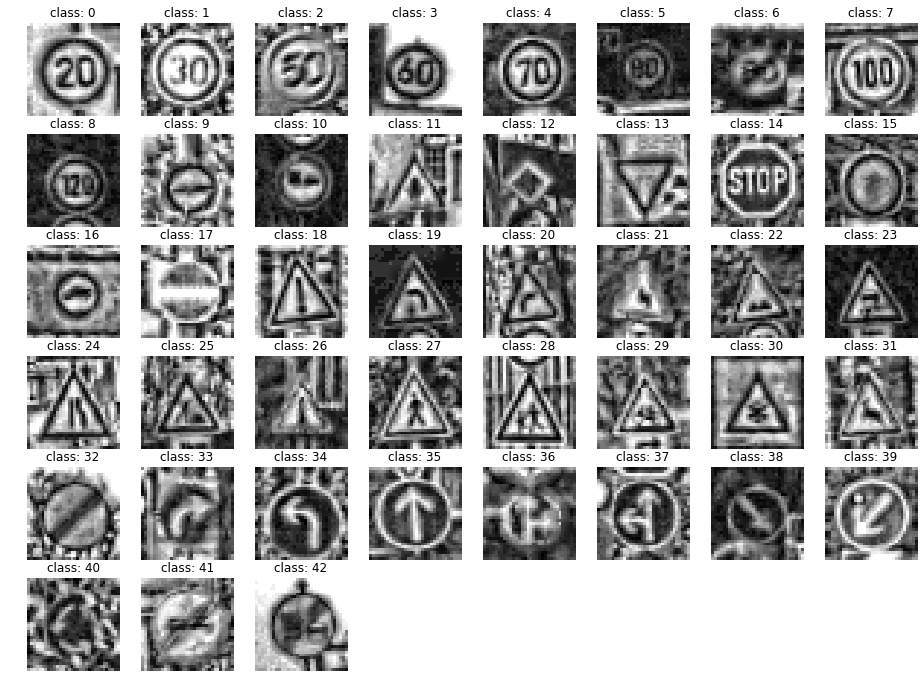

In [62]:
clahe = CLAHE_GRAY()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))    
    plt.imshow(clahe(X_train[i]).squeeze(), cmap='gray')

In [66]:
# Apply CLAHE
X_train_clahe = np.array([clahe(x) for x in X_train])

gray_chan = np.reshape(X_train_clahe[:,:,:,0], -1)/255
print(np.mean(gray_chan))
print(np.std(gray_chan))

0.4714577090373069
0.24148300871438033


In [67]:
data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor(),
    transforms.Normalize((0.4715,),(0.2415,))
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), preprocess)

In [69]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/10] Train loss: 3.566033	Validation loss: 3.492130	 Validation accruacy: 11.338%
[Epoch 2/10] Train loss: 2.727165	Validation loss: 1.838332	 Validation accruacy: 50.227%
[Epoch 3/10] Train loss: 1.076621	Validation loss: 0.883107	 Validation accruacy: 74.308%
[Epoch 4/10] Train loss: 0.574305	Validation loss: 0.663987	 Validation accruacy: 80.771%
[Epoch 5/10] Train loss: 0.395005	Validation loss: 0.519000	 Validation accruacy: 84.603%
[Epoch 6/10] Train loss: 0.303890	Validation loss: 0.490748	 Validation accruacy: 86.735%
[Epoch 7/10] Train loss: 0.244100	Validation loss: 0.415808	 Validation accruacy: 88.934%
[Epoch 8/10] Train loss: 0.198347	Validation loss: 0.425091	 Validation accruacy: 88.662%
[Epoch 9/10] Train loss: 0.165101	Validation loss: 0.381840	 Validation accruacy: 90.204%
[Epoch 10/10] Train loss: 0.139135	Validation loss: 0.369349	 Validation accruacy: 90.181%
Test loss: 0.437424	Test accruacy: 88.638%


## Handling imbalanced dataset

In [ ]:
# Use weighted sampler
class_sample_count = np.bincount(y_train)
weights = 1 / np.array([class_sample_count[y] for y in y_train])
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, 43 * 5000)

In [ ]:
import PIL

# Data augmentation
train_data_transforms = transforms.Compose([
    transforms.ToPILImage(),
#     transforms.RandomAffine(10, translate=(0.2,0.2), scale=(0.8,1.2), shear=10, resample=PIL.Image.BILINEAR),
    transforms.RandomChoice([
        transforms.RandomRotation(20),
        transforms.RandomAffine(0, translate=(0.2, 0.2)),
        transforms.RandomAffine(0, shear=20),
    ]),
    transforms.ToTensor(),
    transforms.Normalize((0.3398, 0.3117, 0.3210), (0.2755, 0.2647, 0.2712))
])
test_data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.3398, 0.3117, 0.3210), (0.2755, 0.2647, 0.2712))
])

train_dataset = PickledDataset(training_file, transform=train_data_transforms)
test_dataset = PickledDataset(testing_file, transform=test_data_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=1)

In [ ]:
balacned_y_train = np.array([], dtype=np.int64)

with torch.no_grad():
    for _, y in train_loader:
        y = y.to(device, dtype=torch.int64)
        balacned_y_train = np.append(balacned_y_train, y.cpu().numpy())

fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(balacned_y_train), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

In [ ]:
with torch.no_grad():
    x, y = next(iter(train_loader))
    x, y = x.to(device).cpu().numpy(), y.to(device).cpu().numpy()
    plt.figure(figsize=(16, 16))
    for i in range(len(y)):
        plt.subplot(8, 8, i+1)
        plt.axis('off')
        plt.title('class: {}'.format(y[i]))
        image = np.transpose(x[i], (1, 2, 0))
        mean = np.array([0.3398, 0.3117, 0.3210])
        std = np.array([0.2755, 0.2647, 0.2712])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        plt.imshow(np.array(image))

In [ ]:
model = BaselineNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1, n_epochs+1):
    train_loss = train()
    valid_loss, accuracy = validation()
    print('[Epoch #{}] Training Loss: {:.6f}\tValidation Loss: {:.6f}\tValidation Accuracy: {:.3f}%'.format(epoch, train_loss, valid_loss, accuracy))

## Pretrained model VS Custom model

## Spatial transformer networks